### SoftmaxThenFc SoftmaxThenConv 需要训练

In [1]:
import torch
from torch.utils import data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from merge_dataset import Dataset
from merge_models import SoftmaxThenFc, Likelyhood, ModLikelyhood, MostVotes, SoftmaxThenConv, LookAsDualClf, SoftmaxThenAvg

In [2]:
fold='4'
path_to_features='./best_model_outputs/{emo}.hdf5'

configs = {'batch_size': 64,
           'shuffle': False,
           'num_workers': 1}
labels = {}
dict_emo = {'a': 0, 'h': 1, 'n': 2, 's': 3}
with open('total.txt', 'r') as f:
    total = f.read().split('\n')
testData = []
for item in total:
    labels[item] = dict_emo[item[4]]
    if 'impro' in item and item.startswith('0{fold}'.format(fold=fold)):  # e.g. 04F
        testData.append(item)

validation_set = Dataset(testData, labels, path1=path_to_features.format(emo='ang'), path2=path_to_features.format(emo='hap'), path3=path_to_features.format(emo='neu'), path4=path_to_features.format(emo='sad'))
validation_generator = data.DataLoader(validation_set, **configs)

In [3]:
validation_set[0]

(tensor([[ 2.2395,  1.6372, -0.2809, -3.1150],
         [ 1.3325,  1.8224, -0.1541, -3.3021],
         [ 1.2792,  1.5243, -0.2708, -2.7512],
         [ 1.1906,  1.7061, -0.1273, -2.2667]]),
 0)

In [4]:
device = torch.device('cuda')

In [5]:
method_to_model = {'a': SoftmaxThenAvg, 'b' : MostVotes,
                  'e' : LookAsDualClf, 'f' : Likelyhood, 'g' : ModLikelyhood}

In [6]:
def get_metrics(model):

    y_pred = torch.LongTensor().to(device)
    y_true = torch.LongTensor().to(device)
    for local_batch, local_labels in validation_generator:
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(
            device)

        outputs=model(local_batch)
        # print('testLoss: ', loss)
        _, predict = torch.max(outputs, 1)
        y_pred = torch.cat([y_pred, predict], 0)
        y_true = torch.cat([y_true, local_labels], 0)
    
    y_pred, y_true = y_pred.cpu(), y_true.cpu()
    confusion = confusion_matrix(y_true, y_pred).astype('float16').T
    wa = precision_score(y_true, y_pred, average='micro')
    ua = recall_score(y_true, y_pred, average='macro')
    test_emotion_recalls = confusion.diagonal() / confusion.sum(0)
    
    return ua,wa, test_emotion_recalls

In [7]:
methods = []
uas, was, angs, haps, neus, sads = [], [], [], [], [], []
for key, value in method_to_model.items():
    model = value().to(device)
    ua, wa, test_emotion_recalls = get_metrics(model)
    methods.append(key)
    uas.append(ua)
    was.append(wa)
    angs.append(test_emotion_recalls[0])
    haps.append(test_emotion_recalls[1])
    sads.append(test_emotion_recalls[2])
    neus.append(test_emotion_recalls[3])

/home/wangce/third_year/merge_model(bi_or_multi)/merge_model/merge_models.py:50: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:28.)
  masked_x = x.masked_fill(mask, -float('inf'))


In [8]:
import pandas as pd
table = pd.DataFrame()
table['method'] = methods
table['UA'] = uas
table['WA'] = was
table['ang'] = angs
table['hap'] = haps
table['neu'] = neus
table['sad'] = sads

In [9]:
table

method        UA        WA       ang       hap       neu       sad
0      a  0.680590  0.698502  0.380859  0.774414  0.888672  0.678223
1      b  0.679985  0.694757  0.380859  0.753906  0.901367  0.684082
2      e  0.706599  0.705993  0.464355  0.733398  0.950684  0.678223
3      f  0.709111  0.707865  0.476074  0.748535  0.950684  0.661133
4      g  0.704853  0.704120  0.464355  0.743652  0.950684  0.661133

In [10]:
for name in ['UA', 'WA', 'ang', 'hap', 'neu', 'sad']:
    table[name] = table[name].apply(lambda x: format(x, '.2%'))

In [11]:
table

method      UA      WA     ang     hap     neu     sad
0      a  68.06%  69.85%  38.09%  77.44%  88.87%  67.82%
1      b  68.00%  69.48%  38.09%  75.39%  90.14%  68.41%
2      e  70.66%  70.60%  46.44%  73.34%  95.07%  67.82%
3      f  70.91%  70.79%  47.61%  74.85%  95.07%  66.11%
4      g  70.49%  70.41%  46.44%  74.37%  95.07%  66.11%

目前我论文里最好的一批：  

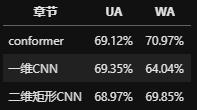  
a)	平均四个模型的分数，取其中最高分的那类为预测结果；  
b)	取投票数最高的那类，若票数一样再取其中分数最高的；  
c)	4个模型共输出16个分数，经过一层线性层，取最高的；  
d)	将4x4的分数，经过一维CNN降维成1x4，取最高的；  
e)	取各分类器主负责情感的输出，之后取最大分数作为预测结果；  
f)	使用似然比，其计算方式为各分类器归一化后，均除以第二高的分数；  
g)	使用似然比，其计算方式为归一化后各分类器擅长那类的分数，除以剩下类里最高的。  

### 原本的四个模型 
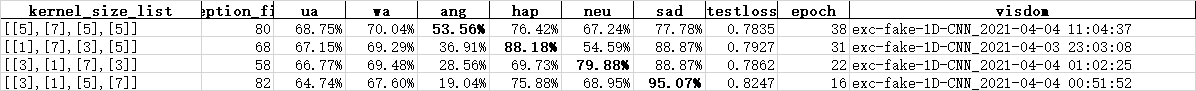

|  章节  |  UA  |  WA  | 
|  ----  | ----  | ----  | 
|  conformer  |  69.12%  |  70.97%  | 
|  一维CNN  |  69.35%  |  64.04%  | 
|  二维矩形CNN  |  68.97%  |  69.85%  | 

In [12]:
table.to_csv('merge_result.csv')

In [ ]:
import os
os._exit(0)